In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
from tqdm import tqdm
from matplotlib.pyplot import *

In [2]:
data = pd.read_csv('All_data.csv')

In [3]:
grades = pd.read_csv('All_grades.csv')

# Data Cleaning

In [4]:
users = grades.user_id.tolist()

In [5]:
user_id = []
for i in data['Description']:
    try:
        discovered_id = i.split("'")[1].replace('.',"")
        _ = int(discovered_id)
        
        user_id.append(discovered_id)
        
    except:
        user_id.append('error')
 

In [6]:
data['user_id'] = user_id
data_users = data.user_id.unique().tolist()

In [7]:
data_users_int = []
for i in data_users:
    try: 
        data_users_int.append(int(i))
    except: 
        continue

In [8]:
not_students = list(set(data_users_int) - set(users))

In [9]:
not_students.append('error')
not_students = [str(i) for i in not_students]
not_students[:10]

['0', '5120', '2', '5123', '5125', '5130', '7179', '5133', '5135', '2064']

In [10]:
data=data[~data.user_id.isin(not_students)]

In [11]:
data = data.reset_index(drop = True)

# Dictionary

In [12]:
data['Time'] = pd.to_datetime(data['Time'], dayfirst=True)

In [13]:
def extract_date(datetime):
    return datetime.day, datetime.week, datetime.month,datetime.year

data['day'], data['week'], data['month'], data['year'] = zip(*data['Time'].map(extract_date))

data['week'] = data['week'] - (data['week'].min() -1)

In [14]:
interval_def_template = {
       'start_date': '',
       'end_date': '',
       'student_ids' : {}
}

In [15]:
def filter_intervals_data(data, time='week'):

    user_activity_dict = {}

    interval_range = sorted(data[time].unique())
    unique_event_dict = {item : 0 for item in data['Event name'].unique()}

    for interval in tqdm(interval_range):
        interval_def_template = {
           'start_date': '',
           'end_date': '',
           'student_ids' : {}
        }

        dict_template = {}

        filtered_data = data[data[time]==interval]
        int_start, int_end = str(filtered_data.Time.min().date()), str(filtered_data.Time.max().date())

        interval_def_template['start_date'], interval_def_template['end_date'] = int_start, int_end

        for user_id in filtered_data.user_id.unique():
            
            user_filtered_events = filtered_data[filtered_data.user_id==user_id]['Event name'].value_counts()
            dict_template[user_id] = dict(unique_event_dict)

            for event, count in dict(user_filtered_events).items():
                dict_template[user_id][event] = count
            
            dict_template[user_id]['type'] = filtered_data[filtered_data.user_id==user_id]['type'].unique()[0]
            dict_template[user_id]['level'] = filtered_data[filtered_data.user_id==user_id]['level'].unique()[0]

        interval_def_template['student_ids'] = dict_template

        user_activity_dict[f"{time}_{interval}"] = interval_def_template
        
    return user_activity_dict
    


# Dict to Dataframe and Merging with Grades

In [16]:
user_filtered_events = filter_intervals_data(data, time='year')

100%|██████████| 18/18 [00:35<00:00,  1.96s/it]


In [17]:
total_user_activity = []
time_interval_list = []

for time_interval, user_events in user_filtered_events.items():
    total_user_activity.append(
        pd.DataFrame(user_filtered_events[f'{time_interval}']['student_ids'].values(), index=user_filtered_events[f'{time_interval}']['student_ids'].keys()))
    
for time_interval, user_events in user_filtered_events.items():
    time_list = [time_interval for i in range(len(user_filtered_events[time_interval]['student_ids'].keys()))]
    time_interval_list+=time_list

In [18]:
k = pd.concat(total_user_activity).reset_index()

In [19]:
time_interval_df = pd.DataFrame(time_interval_list, columns = ['time_interval'])

In [20]:
final = pd.concat([time_interval_df, k], axis=1)

In [21]:
final.rename(columns={'index': 'user_id'},inplace =True)

In [22]:
final.user_id = final.user_id.astype('int')

In [23]:
final = final.merge(grades, on  = 'user_id',how = 'left')

In [24]:
final.dropna(inplace = True)

In [25]:
final.head()

,time_interval,user_id,The status of the submission has been viewed.,Course module viewed,Feedback viewed,Course viewed,Grade user report viewed,User profile viewed,Course activity completion updated,Course user report viewed,...,Subscription created,Subscription deleted,Group member added,Choice answer deleted,Grade item updated,Recent activity viewed,An online text has been uploaded.,type,level,Grades
0,week_1,1943,0,16,0,46,0,22,15,0,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0
1,week_1,2666,0,8,0,14,0,0,0,0,...,0,0,0,0,0,0,0,Quantitative,undergrad,3.7
2,week_1,1931,0,1,0,4,0,0,0,1,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0
3,week_1,2013,0,46,0,49,1,2,2,0,...,0,0,0,0,0,0,0,Quantitative,undergrad,3.7
4,week_1,2385,0,13,0,23,0,0,2,0,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0


# Data Visualization

In [165]:
undergrad = final[final.level == 'undergrad']
grad = final[final.level == 'grad'] 
Quantitative = final[final.type == 'Quantitative']
Qualitative = final[final.type == 'Qualitative']

In [166]:
print (plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [167]:
plt.style.use('ggplot')

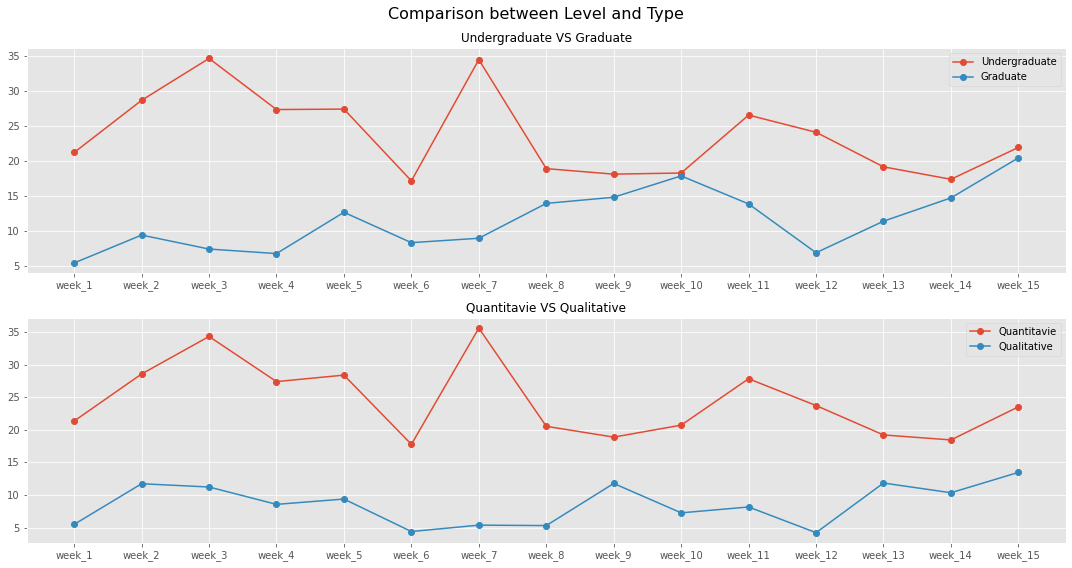

In [168]:

plt.figure(figsize=(15, 8))


plt.subplot(2,1,1)
plt.suptitle('Comparison between Level and Type',fontsize=16)
plt.plot(undergrad.groupby('time_interval',sort = False)['Course viewed'].mean()[:15],marker= 'o')
plt.plot(grad.groupby('time_interval',sort = False)['Course viewed'].mean()[:15],marker= 'o')
plt.legend(['Undergraduate','Graduate'])
plt.title('Undergraduate VS Graduate',fontsize=12)
plt.tight_layout()

plt.subplot(2,1,2)
plt.plot(Quantitative.groupby('time_interval',sort = False)['Course viewed'].mean()[:15],marker= 'o')
plt.plot(Qualitative.groupby('time_interval',sort = False)['Course viewed'].mean()[:15],marker= 'o')
plt.legend(['Quantitavie','Qualitative'])
plt.title("Quantitavie VS Qualitative",fontsize=12)
plt.tight_layout()
plt.show()

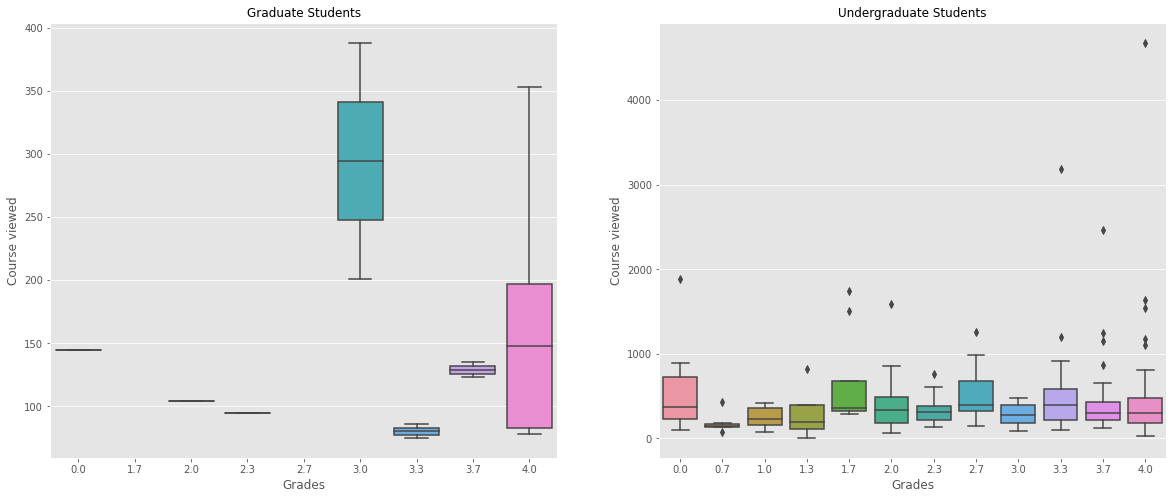

In [169]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.boxplot(grad.Grades, grad.groupby('user_id')['Course viewed'].sum())
plt.title("Graduate Students",fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(undergrad.Grades, undergrad.groupby('user_id')['Course viewed'].sum())
plt.title("Undergraduate Students",fontsize=12)
plt.show()

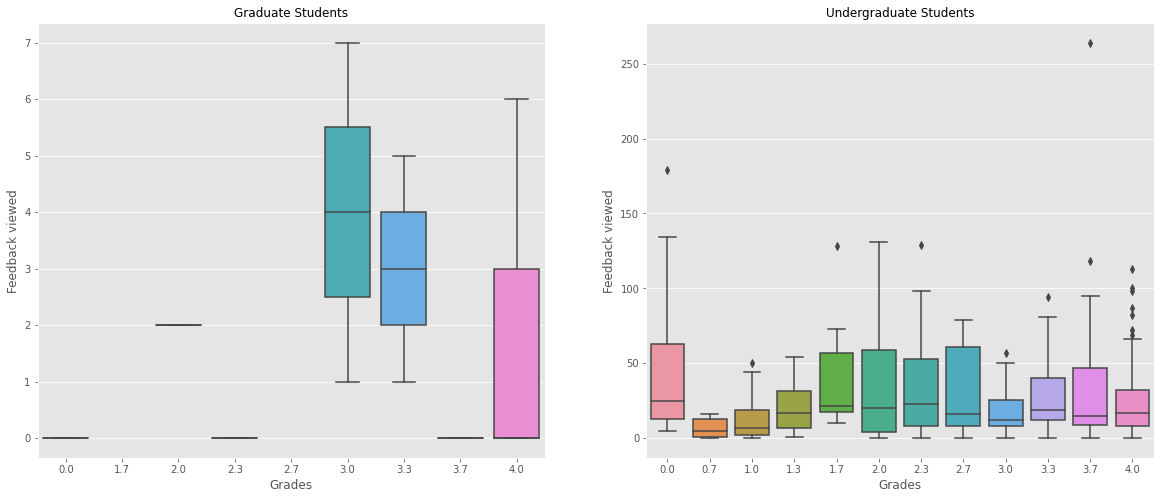

In [172]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.boxplot(grad.Grades, grad.groupby('user_id')['Feedback viewed'].sum())
plt.title("Graduate Students",fontsize=12)

plt.subplot(1,2,2)
sns.boxplot(undergrad.Grades, undergrad.groupby('user_id')['Feedback viewed'].sum())
plt.title("Undergraduate Students",fontsize=12)
plt.show()

# Yearly


## Data

In [89]:
user_filtered_events = filter_intervals_data(data, time='year')

total_user_activity = []
time_interval_list = []

for time_interval, user_events in user_filtered_events.items():
    total_user_activity.append(
        pd.DataFrame(user_filtered_events[f'{time_interval}']['student_ids'].values(), index=user_filtered_events[f'{time_interval}']['student_ids'].keys()))
    
for time_interval, user_events in user_filtered_events.items():
    time_list = [time_interval for i in range(len(user_filtered_events[time_interval]['student_ids'].keys()))]
    time_interval_list+=time_list

k = pd.concat(total_user_activity).reset_index()

time_interval_df = pd.DataFrame(time_interval_list, columns = ['time_interval'])

final_yearly = pd.concat([time_interval_df, k], axis=1)

final_yearly.rename(columns={'index': 'user_id'},inplace =True)

final_yearly.user_id = final_yearly.user_id.astype('int')

final_yearly = final_yearly.merge(grades, on  = 'user_id',how = 'left')

final_yearly.dropna(inplace = True)

final_yearly.head()

100%|██████████| 1/1 [00:28<00:00, 28.17s/it]


,time_interval,user_id,The status of the submission has been viewed.,Course module viewed,Feedback viewed,Course viewed,Grade user report viewed,User profile viewed,Course activity completion updated,Course user report viewed,...,Subscription created,Subscription deleted,Group member added,Choice answer deleted,Grade item updated,Recent activity viewed,An online text has been uploaded.,type,level,Grades
0,year_2020,2308,312,869,110,805,89,14,58,0,...,0,0,0,0,0,0,0,Quantitative,undergrad,2.3
1,year_2020,1931,190,608,32,332,7,3,69,208,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0
2,year_2020,2084,257,416,75,353,2,1,69,36,...,0,0,0,0,0,0,0,Quantitative,undergrad,2.7
3,year_2020,2378,331,725,113,564,39,2,57,1,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0
4,year_2020,1943,544,1114,179,1890,152,33,85,9,...,0,0,0,0,0,0,0,Quantitative,undergrad,4.0


In [149]:
c = []
c.append('user_id')
for i in final.columns:
    if sum(final_yearly[i].values == 0) > 0.6*len(final_yearly):
        c.append(i)
        finalsmall = final_yearly.drop(c, 1)

In [150]:
finalsmall

,time_interval,The status of the submission has been viewed.,Course module viewed,Feedback viewed,Course viewed,Grade user report viewed,User profile viewed,Course activity completion updated,Course user report viewed,A submission has been submitted.,...,Quiz attempt reviewed,Quiz attempt submitted,Quiz attempt viewed,User graded,Quiz attempt summary viewed,Quiz attempt started,Clicked join meeting button,type,level,Grades
0,year_2020,312,869,110,805,89,14,58,0,23,...,9,6,201,4,6,8,0,Quantitative,undergrad,2.3
1,year_2020,190,608,32,332,7,3,69,208,29,...,8,6,302,6,4,7,0,Quantitative,undergrad,4.0
2,year_2020,257,416,75,353,2,1,69,36,27,...,6,7,330,5,5,9,0,Quantitative,undergrad,2.7
3,year_2020,331,725,113,564,39,2,57,1,32,...,56,7,319,7,6,8,0,Quantitative,undergrad,4.0
4,year_2020,544,1114,179,1890,152,33,85,9,36,...,41,6,223,4,6,8,0,Quantitative,undergrad,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,year_2020,38,103,2,107,12,1,13,0,5,...,2,1,32,0,1,1,0,Quantitative,grad,3.0
470,year_2020,78,350,5,265,2,1,43,13,8,...,4,1,16,0,1,1,0,Quantitative,grad,4.0
471,year_2020,20,140,0,148,0,0,22,15,6,...,1,1,22,0,1,1,0,Quantitative,grad,3.7
472,year_2020,34,203,0,112,11,0,23,0,3,...,9,1,6,0,0,1,0,Quantitative,grad,3.0


In [151]:
undergrad_quan = finalsmall[(finalsmall.level == 'undergrad') & (finalsmall.type == 'Quantitative')]
grad_quan = finalsmall[(finalsmall.level == 'grad') & (finalsmall.type == 'Quantitative')] 
undergrad_qual = finalsmall[(finalsmall.level == 'undergrad') & (finalsmall.type == 'Qualitative')]
grad_qual = finalsmall[(finalsmall.level == 'grad') & (finalsmall.type == 'Qualitative')]

# Yearly Visualizations

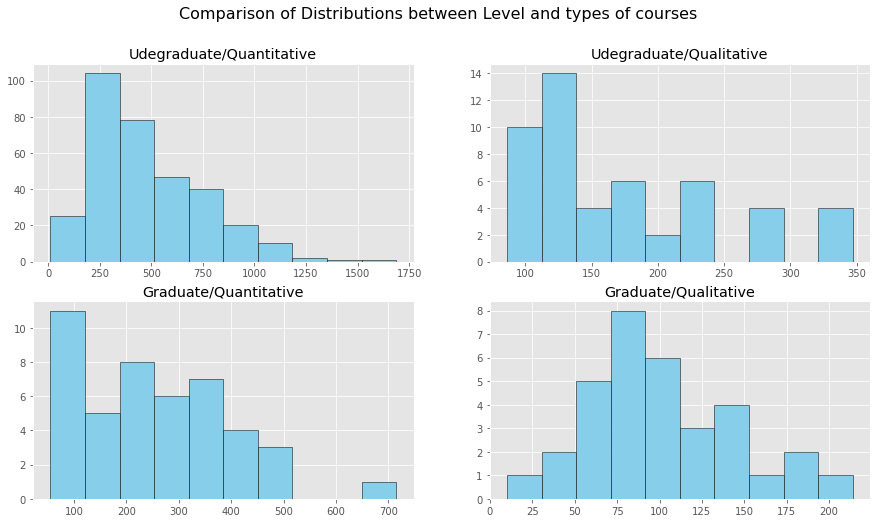

In [202]:
plt.figure(figsize=(15,8))

plt.subplot(2,2,1)
plt.suptitle('Comparison of Distributions between Level and types of courses',fontsize=16)
plt.title('Udegraduate/Quantitative')
plt.hist(undergrad_quan['Course module viewed'],bins = 10, color='skyblue',ec='black')

plt.subplot(2,2,2)
plt.hist(undergrad_qual['Course module viewed'],bins = 10, color='skyblue',ec='black')
plt.title('Udegraduate/Qualitative')

plt.subplot(2,2,3)
plt.hist(grad_quan['Course module viewed'],bins = 10, color='skyblue',ec='black')
plt.title('Graduate/Quantitative')

plt.subplot(2,2,4)
plt.hist(grad_qual['Course module viewed'],bins = 10, color='skyblue',ec='black')
plt.title('Graduate/Qualitative')

plt.show()
